In [10]:
import torch
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms,models
import random
import json
import matplotlib.pyplot as plt

class_idx = json.load(open("imagenet_class_index.json"))
class_names = [class_idx[str(k)][1] for k in range(len(class_idx))]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True

setup_seed(3407)

In [11]:
img_label_batch = np.load("img_label_batch_10.npz")

In [12]:
model = models.inception_v3(pretrained=True)
model.eval()
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
norm_layer = transforms.Normalize(mean, std)
sfmx = nn.Softmax(dim=-1)
model = nn.Sequential(norm_layer, model, sfmx).to(device)

c:\Users\Zhang\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Zhang\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
percentile = 80
upperbound = 99
# input
def plot_img(plt, img,ex):
    pred = model(img.to(device)).argmax(-1).item()
    img = img.squeeze().cpu().numpy()
    plt.title("Pred:{}".format(class_names[pred]))
    ex = np.transpose(img, (1,2,0))
    plt.imshow(ex)
    return plt

# heatmap
def plot_hm(plt, img, ex):
    plt.title("Heatmap")
    ex = np.mean(ex, axis=0)
    q = np.percentile(ex, percentile)
    u = np.percentile(ex, upperbound)
    # q=0
    ex[ex<q] = q
    ex[ex>u] = u
    ex = (ex-q)/(u-q+1e-8)
    plt.imshow(ex, cmap='gray')

# input * heatmap
def plot_hm_img(plt, img, ex):
    # pred, img, ex = example
    plt.title("Input * heatmap")
    ex = np.expand_dims(np.mean(ex, axis=0), axis=0)
    q = np.percentile(ex, percentile)
    u = np.percentile(ex, upperbound)
    # q=0
    ex[ex<q] = q
    ex[ex>u] = u
    ex = (ex-q)/(u-q)
    ex = np.transpose(ex, (1,2,0))
    img = np.transpose(img, (1,2,0))

    img = img * ex
    plt.imshow(img)
    
def return_hm(ex):
    ex = np.mean(ex, axis=0)
    q = np.percentile(ex, percentile)
    u = np.percentile(ex, upperbound)
    # q=0
    ex[ex<q] = q
    ex[ex>u] = u
    ex = (ex-q)/(u-q+1e-8)
    return ex

def return_hm_img(img, ex):
    ex = np.expand_dims(np.mean(ex, axis=0), axis=0)
    q = np.percentile(ex, percentile)
    u = np.percentile(ex, upperbound)
    # q=0
    ex[ex<q] = q
    ex[ex>u] = u
    ex = (ex-q)/(u-q)
    ex = np.transpose(ex, (1,2,0))
    img = np.transpose(img, (1,2,0))

    img = img * ex
    return img

In [14]:
img_batch = torch.from_numpy(img_label_batch['img_batch']).float().to(device)
label_batch = torch.from_numpy(img_label_batch['label_batch']).long().to(device)

In [15]:
from saliency.la import la

In [16]:
attribution = la(model, img_batch, label_batch)

In [27]:
IDX = 0

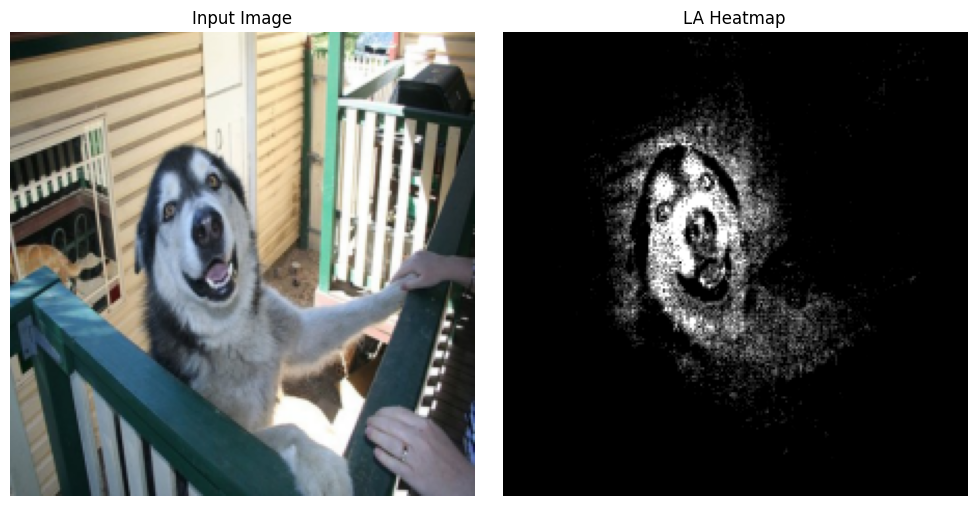

In [28]:
la_attr = attribution[IDX]
img = img_batch[IDX]

hm_la = return_hm(la_attr)
fig,axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(np.transpose(img.cpu().numpy(), (1, 2, 0)))
axes[0].axis('off')
axes[0].set_title("Input Image")
axes[1].imshow(hm_la, cmap='gray')
axes[1].axis('off')
axes[1].set_title("LA Heatmap")
plt.tight_layout()
plt.show()